The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Transformer
:label:`sec_transformer`

我们在 :numref:`subsec_cnn-rnn-self-attention`中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。值得注意的是，自注意力同时具有并行计算和最短的最大路径长度这两个优势。因此，使用自注意力来设计深度架构是很有吸引力的。对比之前仍然依赖循环神经网络实现输入表示的自注意力模型 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017`，transformer模型完全基于注意力机制，没有任何卷积层或循环神经网络层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 模型

Transformer作为编码器－解码器架构的一个实例，其整体架构图在 :numref:`fig_transformer`中展示。正如所见到的，transformer是由编码器和解码器组成的。与 :numref:`fig_s2s_attention_details`中基于Bahdanau注意力实现的序列到序列的学习相比，transformer的编码器和解码器是基于自注意力的模块叠加而成的，源（输入）序列和目标（输出）序列的*嵌入*（embedding）表示将加上*位置编码*（positional encoding），再分别输入到编码器和解码器中。

![transformer架构](http://d2l.ai/_images/transformer.svg)
:width:`500px`
:label:`fig_transformer`

图 :numref:`fig_transformer`中概述了transformer的架构。从宏观角度来看，transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。第一个子层是*多头自注意力*（multi-head self-attention）汇聚；第二个子层是*基于位置的前馈网络*（positionwise feed-forward network）。具体来说，在计算编码器的自注意力时，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet`中残差网络的启发，每个子层都采用了*残差连接*（residual connection）。在transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。在残差连接的加法计算之后，紧接着应用*层规范化*（layer normalization） :cite:`Ba.Kiros.Hinton.2016`。因此，输入序列对应的每个位置，transformer编码器都将输出一个$d$维表示向量。

Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为*编码器－解码器注意力*（encoder-decoder attention）层。在编码器－解码器注意力中，查询来自前一个解码器层的输出，而键和值来自整个编码器的输出。在解码器自注意力中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能考虑该位置之前的所有位置。这种*掩蔽*（masked）注意力保留了*自回归*（auto-regressive）属性，确保预测仅依赖于已生成的输出词元。

我们已经描述并实现了基于缩放点积多头注意力 :numref:`sec_multihead-attention`和位置编码 :numref:`subsec_positional-encoding`。接下来，我们将实现transformer模型的剩余部分。


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from d2l import tensorflow as d2l

## [**基于位置的前馈网络**]

基于位置的前馈网络对序列中的所有位置的表示进行变换时使用的是同一个多层感知机（MLP），这就是称前馈网络是*基于位置的*（positionwise）的原因。在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [2]:
#@save
class PositionWiseFFN(tf.keras.layers.Layer):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super().__init__(*kwargs)
        self.dense1 = tf.keras.layers.Dense(ffn_num_hiddens)
        self.relu = tf.keras.layers.ReLU()
        self.dense2 = tf.keras.layers.Dense(ffn_num_outputs)

    def call(self, X):
        return self.dense2(self.relu(self.dense1(X)))

下面的例子显示，[**改变张量的最里层维度的尺寸**]，会改变成基于位置的前馈网络的输出尺寸。因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。


In [3]:
ffn = PositionWiseFFN(4, 8)
ffn(tf.ones((2, 3, 4)))[0]

<tf.Tensor: shape=(3, 8), dtype=float32, numpy=
array([[-0.16091488,  0.10357381,  0.13643846, -0.25162098, -0.5405591 ,
         0.01230582, -0.344257  , -0.32032433],
       [-0.16091488,  0.10357381,  0.13643846, -0.25162098, -0.5405591 ,
         0.01230582, -0.344257  , -0.32032433],
       [-0.16091488,  0.10357381,  0.13643846, -0.25162098, -0.5405591 ,
         0.01230582, -0.344257  , -0.32032433]], dtype=float32)>

## 残差连接和层规范化

现在让我们关注 :numref:`fig_transformer`中的“*加法和规范化*（add&norm）”组件。正如在本节开头所述，这是由残差连接和紧随其后的层规范化组成的。两者都是构建有效的深度架构的关键。

在 :numref:`sec_batch_norm`中，我们解释了在一个小批量的样本内基于批量规范化对数据进行重新中心化和重新缩放的调整。层规范化和批量规范化的目标相同，但层规范化是基于特征维度进行规范化。尽管批量规范化在计算机视觉中被广泛应用，但在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。

以下代码[**对比不同维度的层规范化和批量规范化的效果**]。


In [4]:
ln = tf.keras.layers.LayerNormalization()
bn = tf.keras.layers.BatchNormalization()
X = tf.constant([[1, 2], [2, 3]], dtype=tf.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X, training=True))

layer norm: tf.Tensor(
[[-0.998006   0.9980061]
 [-0.9980061  0.998006 ]], shape=(2, 2), dtype=float32) 
batch norm: tf.Tensor(
[[-0.998006   -0.9980061 ]
 [ 0.9980061   0.99800587]], shape=(2, 2), dtype=float32)


现在我们可以[**使用残差连接和层规范化**]来实现`AddNorm`类。暂退法也被作为正则化方法使用。


In [5]:
#@save
class AddNorm(tf.keras.layers.Layer):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.ln = tf.keras.layers.LayerNormalization(normalized_shape)

    def call(self, X, Y, **kwargs):
        return self.ln(self.dropout(Y, **kwargs) + X)

残差连接要求两个输入的形状相同，以便[**加法操作后输出张量的形状相同**]。


In [6]:
add_norm = AddNorm([1, 2], 0.5)
add_norm(tf.ones((2, 3, 4)), tf.ones((2, 3, 4)), training=False).shape

TensorShape([2, 3, 4])

## 编码器

有了组成transformer编码器的基础组件，现在可以先[**实现编码器中的一个层**]。下面的`EncoderBlock`类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。


In [7]:
#@save
class EncoderBlock(tf.keras.layers.Layer):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens,
                                                num_heads, dropout, bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def call(self, X, valid_lens, **kwargs):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens, **kwargs), **kwargs)
        return self.addnorm2(Y, self.ffn(Y), **kwargs)

正如我们所看到的，[**transformer编码器中的任何层都不会改变其输入的形状**]。


In [8]:
X = tf.ones((2, 100, 24))
valid_lens = tf.constant([3, 2])
norm_shape = [i for i in range(len(X.shape))][1:]
encoder_blk = EncoderBlock(24, 24, 24, 24, norm_shape, 48, 8, 0.5)
encoder_blk(X, valid_lens, training=False).shape

TensorShape([2, 100, 24])

在实现下面的[**transformer编码器**]的代码中，我们堆叠了`num_layers`个`EncoderBlock`类的实例。由于我们使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的嵌入表示的值需要先乘以嵌入维度的平方根进行重新缩放，然后再与位置编码相加。


In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hiddens, num_heads,
                 num_layers, dropout, bias=False, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [EncoderBlock(
            key_size, query_size, value_size, num_hiddens, norm_shape,
            ffn_num_hiddens, num_heads, dropout, bias) for _ in range(
            num_layers)]

    def call(self, X, valid_lens, **kwargs):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(
            tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens, **kwargs)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来[**创建一个两层的transformer编码器**]。
Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。


In [10]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [1, 2], 48, 8, 2, 0.5)
encoder(tf.ones((2, 100)), valid_lens, training=False).shape

TensorShape([2, 100, 24])

## 解码器

如 :numref:`fig_transformer`所示，[**transformer解码器也是由多个相同的层组成**]。在`DecoderBlock`类中实现的每个层包含了三个子层：解码器自注意力、“编码器-解码器”注意力和基于位置的前馈网络。这些子层也都被残差连接和紧随的层规范化围绕。

正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。关于*序列到序列模型*（sequence-to-sequence model），在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。


In [11]:
class DecoderBlock(tf.keras.layers.Layer):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def call(self, X, state, **kwargs):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = tf.concat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if kwargs["training"]:
            batch_size, num_steps, _ = X.shape
           # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = tf.repeat(tf.reshape(tf.range(1, num_steps + 1),
                                                 shape=(-1, num_steps)), repeats=batch_size, axis=0)

        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens, **kwargs)
        Y = self.addnorm1(X, X2, **kwargs)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens, **kwargs)
        Z = self.addnorm2(Y, Y2, **kwargs)
        return self.addnorm3(Z, self.ffn(Z), **kwargs), state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，[**编码器和解码器的特征维度都是`num_hiddens`。**]


In [12]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [1, 2], 48, 8, 0.5, 0)
X = tf.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state, training=False)[0].shape

TensorShape([2, 100, 24])

现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的[**transformer解码器**]。最后，通过一个全连接层计算所有`vocab_size`个可能的输出词元的预测值。解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便日后可视化的需要。


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_hidens, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = [DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                  ffn_num_hiddens, num_heads, dropout, i) for i in range(num_layers)]
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def call(self, X, state, **kwargs):
        X = self.pos_encoding(self.embedding(X) * tf.math.sqrt(tf.cast(self.num_hiddens, dtype=tf.float32)), **kwargs)
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]  # 解码器中2个注意力层
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state, **kwargs)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## [**训练**]

依照transformer架构来实例化编码器－解码器模型。在这里，指定transformer的编码器和解码器都是2层，都使用4头注意力。与 :numref:`sec_seq2seq_training`类似，为了进行序列到序列的学习，我们在“英语－法语”机器翻译数据集上训练transformer模型。


loss 0.030, 1041.1 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f511c0ae340>


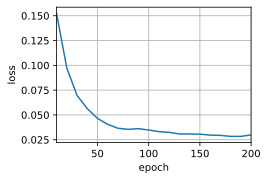

In [14]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [2]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
    ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
    ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用transformer模型[**将一些英语句子翻译成法语**]，并且计算它们的BLEU分数。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000


i lost . => j'ai perdu .,  bleu 1.000


he's calm . => il est calme ici .,  bleu 0.752


i'm home . => je suis chez moi .,  bleu 1.000


当进行最后一个英语到法语的句子翻译工作时，让我们[**可视化transformer的注意力权重**]。编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。


In [16]:
enc_attention_weights = tf.reshape(
    tf.concat(net.encoder.attention_weights, 0),
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

TensorShape([2, 4, 10, 10])

在编码器的自注意力中，查询和键都来自相同的输入序列。因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


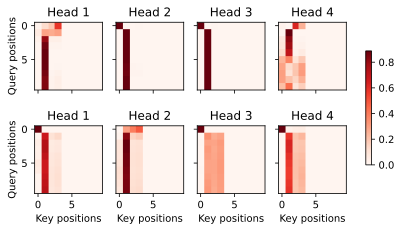

In [17]:
d2l.show_heatmaps(
    enc_attention_weights, xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

[**为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。**]例如，我们用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以*序列开始词元*（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。


In [18]:
dec_attention_weights_2d = [head[0] for step in dec_attention_weight_seq
                            for attn in step
                            for blk in attn for head in blk]
dec_attention_weights_filled = tf.convert_to_tensor(
    np.asarray(pd.DataFrame(dec_attention_weights_2d).fillna(
        0.0).values).astype(np.float32))
dec_attention_weights = tf.reshape(dec_attention_weights_filled, shape=(
    -1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = tf.transpose(
    dec_attention_weights, perm=(1, 2, 3, 0, 4))
print(dec_self_attention_weights.shape, dec_inter_attention_weights.shape)

(2, 4, 6, 10) (2, 4, 6, 10)


由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


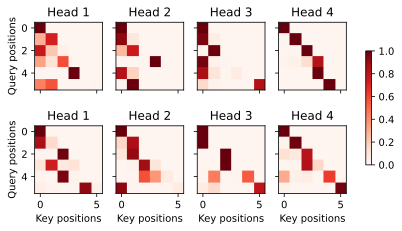

In [19]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，[**输出序列的查询不会与输入序列中填充位置的词元进行注意力计算**]。


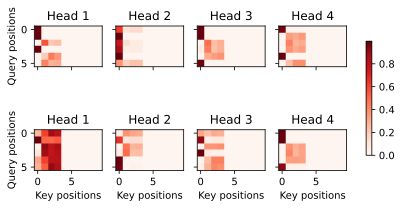

In [20]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

尽管transformer架构是为了“序列到序列”的学习而提出的，但正如我们将在本书后面提及的那样，transformer编码器或transformer解码器通常被单独用于不同的深度学习任务中。

## 小结

* transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
* 在transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
* transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
* transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。

## 练习

1. 在实验中训练更深的transformer将如何影响训练速度和翻译效果？
1. 在transformer中使用加性注意力取代缩放点积注意力是不是个好办法？为什么？
1. 对于语言模型，我们应该使用transformer的编码器还是解码器，或者两者都用？如何设计？
1. 如果输入序列很长，transformer会面临什么挑战？为什么？
1. 如何提高transformer的计算速度和内存使用效率？提示：可以参考论文 :cite:`Tay.Dehghani.Bahri.ea.2020`。
1. 如果不使用卷积神经网络，如何设计基于transformer模型的图像分类任务？提示：可以参考Vision Transformer :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。
